In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# define filepath to read data
dir_path = '../CMAPSSData/'

# define column names for easy indexing
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)] 
col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv((dir_path+'train_FD001.txt'), sep='\s+', header=None, names=col_names)
test = pd.read_csv((dir_path+'test_FD001.txt'), sep='\s+', header=None, names=col_names)
y_test = pd.read_csv((dir_path+'RUL_FD001.txt'), sep='\s+', header=None, names=['RUL'])

# inspect first few rows
train.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [3]:
def add_remaining_useful_life(df): # RUL col을 추가
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame
  
train = add_remaining_useful_life(train)
train[index_names+['RUL']].head()

,unit_nr,time_cycles,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


In [4]:
# 필요없는 센서값과 라벨 버리기
drop_sensors = ['s_1','s_5','s_6','s_10','s_16','s_18','s_19']
drop_labels = index_names+setting_names+drop_sensors

X_train = train.drop(drop_labels, axis=1)
y_train = X_train.pop('RUL')

# Since the true RUL values for the test set are only provided for the last time cycle of each enginge, 
# the test set is subsetted to represent the same
X_test = test.groupby('unit_nr').last().reset_index().drop(drop_labels, axis=1)

In [5]:
# 모델 성능 평가 RMSE 
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

저번에는 단순 선형 회귀 모델을 이용했다. 즉 RUL은 시간이 지남에 따라 선형적으로 감소한다고 가정함.  
그런데 성능이 별로였다.  
센서 그림을 그려봤을 때 대부분의 센서값들이 처음에는 다소 일정하다. 그러다가 어느 순간부터
RUL이 선형적으로 감소하고 있다.  

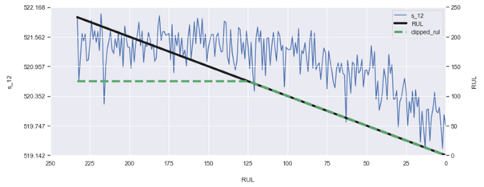

In [6]:
from IPython.display import Image

Image('./FD001_EDA2_RUL.png')

-> 선형 회귀가 아니라 RUL이 상수로 시작하여 일정 시간이 지나면 선형적으로 감소하게끔 정의한다.

그렇게 한다면 다음과 같은 2가지 효과가 있을 것으로 예상된다.  
1. 초기에 일정한 RUL은 초기에 일정한 평균 센서 신호와 더 나은 상관관계를 보일 것.
2. RUL의 피크 값이 낮으면 목표 변수의 퍼짐(spread)이 낮아져 선을 맞추기가 더 쉬워진다. 

-> https://towardsdatascience.com/the-importance-of-problem-framing-for-supervised-predictive-maintenance-solutions-cc8646826093  
에 따르면 125에서 상수 RUL을 정했을 때 가장 모델 성능이 좋았다고 한다.  

-> 저 상수 RUL을 몇으로 할 것이냐도 중요한 하이퍼파라미터가 될 것으로 보인다.
test set의 실제 RUL은 그대로 유지한다.

In [9]:
X_train

,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21
0,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735
20627,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594
20628,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333
20629,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640


In [7]:
y_train

0        191
1        190
2        189
3        188
4        187
        ... 
20626      4
20627      3
20628      2
20629      1
20630      0
Name: RUL, Length: 20631, dtype: int64

In [13]:
## Clipped RUL  - 상수 RUL 125로 하기
y_train_clipped = y_train.clip(upper=125)

# create and fit model
lm = LinearRegression()
lm.fit(X_train, y_train_clipped)

# predict and evaluate
y_hat_train = lm.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = lm.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:21.491018701515145, R2:0.7340432868050514
test set RMSE:21.900213406892572, R2:0.7222608196545719


RUL을 clipping (상수 RUL로 제한 125로) 했을 때 아까 RMSE 31.95 -> 21.90으로 줄었다!   
시각화해봤을 때 대부분 센서값들이 처음에 상수로 나타나는 경향이 보였기에 그렇게 제한한 것인데  
간단하고 쉬운 방법이지만 성능이 30% 정도나 상승하였다.
이제 SVR을 한번 보자.